# Introduction to Reservoir Computing

## What is a reservoir?

A reservoir is a high-dimensional dynamical system with two special properties: the <b>fading memory</b> property, and the <b>separation</b> property. The fading memory property states that: 1) The reservoir must have recurrent feedback such that the state of the reservoir at any time reflects its past input history. In other words, the system must have a dynamical memory.
2) This memory must fade over time, such that the reservoir eventually forgets any initial conditions. The separation property states that different input sequences should result in different reservoir trajectories.

These essential properties allow input data to be projected into a high-dimensional space of functions containing contextual information about recent past inputs. The information within the reservoir can then be fed into a linear classifier, which uses linear combinations of these functions to perform the desired classification or prediction task. This makes reservoir computing similar to Kernel methods such as Support Vector Machines (SVMs).

## How are reservoirs useful?

Prediction and classification of time-series data is notoriously difficult, especially in real time. For example, let's say you want to track the motion of an object using a feed-forward neural network. In this case, not only would you need a set of N inputs to identify the object in a still image, you would need a separate set of N inputs for each additional time-frame relevant to the motion of the object. This could be hundreds of frames! This procedure represents time extrinsically, as an extra set of inputs to the network, which turns out to be very inefficient.

A more clever method is to use a recurrent neural network capable of capturing the true dynamics of the object being tracked. In this case, time is represented intrinsically rather than extrinsically. While they are extremely powerful, recurrent neural networks are very difficult to train. The intuitive technique of backpropagation through time (BPTT) often either fails completely or leads to excruciatingly slow learning. Alternatives such as Long Short Term Memory (LSTM) overcome many of the problems of BPTT, but the models are often very complex and slow to train.

This is where reservoir computing comes in. Instead of attempting to learn the weights of the recurrent neural network, we instead create a random network with macroscopic dynamics (i.e. time constants, length scales) similar to the system we're trying to model or predict. Then, we train a linear classifier to interpret the current state of the reservoir, which naturally contains information about its past inputs. This is often much more efficient for simple problems than training an LSTM network, and yields similar results. Importantly, reservoir computing is highly tolerant to the inherent randomness and imperfections of analog neuromorphic hardware, which makes these architectures perfect substrates for reservoir computing.

# The Reservoir Computing Architecture

<img src="reservoir.png">

## Input and Reservoir

In any reservoir computing architecture, we are primarily concerned with three variables. The first is the input vector $\textbf{X}(t)$. This is the time-series of interest, which may have one or many dimensions. The second is the current state of the reservoir, $\textbf{Z}(t)$. The nodes in the reservoir are typically modeled as nonlinear leaky integrators. At any given time, the state of the reservoir $\textbf{Z}(t)$ is given by:

$$\textbf{Z}(t) = (1-a)\cdot\textbf{Z}(t-1) + a\cdot\sigma(\textbf{W}^{in}\textbf{X}(t) + \textbf{W}^{res}\textbf{Z}(t-1))   $$

Here, $a$ is the leak-rate, $\textbf{W}^{in}$ is the set of weights from the input to the reservoir, and $\textbf{W}^{res}$ is the set of recurrent weights from the reservoir to itself. $\sigma(\cdot)$ is a nonlinear (usually sigmoid) activation function. The last variable of interest is the readout:

$$\textbf{Y}(t) = \textbf{W}^{out}\textbf{Z}(t)$$

The readout uses a third set of weights, $\textbf{W}^{out}$, to perform a linear classification on the reservoir state $\textbf{Z}(t)$, arriving at the final output classification or regression $\textbf{Y}(t)$. The output weights $\textbf{W}^{out}$ are the only weights trained in the network.

## Readout and Classifier

As inputs are presented to the reservoir, the reservoir states $\textbf{Z}(t)$ are used as input for the linear classifier $\textbf{W}^{out}$, which has the advantage of quick and easy training. The best training method for reservoir computing is generally considered to be ridge regression, so this is the method we will be using in this tutorial. Ridge regression can be viewed as a regularized version of standard linear regression.

# Classification of Spoken Commands

In this section, we'll be classifying spoken commands using a new dataset released by Google called the Speech Commands Dataset. It consists of ten spoken commands such as "stop", "go", "up", and "down", plus a variety of other distractor words, and is meant to enable simple speech interfaces for robots and other devices. The small vocabulary and lack of long-range time dependencies make this dataset perfectly suited for reservoir computing.

Now, let's get started. First, we need to do some imports.

In [1]:
from __future__ import division
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import eig
from sklearn.linear_model import Ridge
%matplotlib inline

Next, we'll load in the data. In this example, we'll be using speech data that has already been preprocessed using the Lyon Passive Ear model, which separates the speech waveform into its constituent frequencies in the same way as a human ear (similar to a Fourier Transform).

In [2]:
#Load speech commands data from dir

rootDir = 'Lyon_Speech_Commands_Small\*'
paths = glob.glob(rootDir)

data = []

for n,i in enumerate(paths):
    print 'loading ' + paths[n][27:]
    block = []
    files = glob.glob(i + '\*')
    
    for j in files:
        X = np.loadtxt(j)
        block.append(X)
        
    data.append(block)
    
print("Finished Loading")

loading background_noise_lyon
loading bed_lyon
loading bird_lyon
loading cat_lyon
loading dog_lyon
loading down_lyon
loading eight_lyon
loading five_lyon
loading four_lyon
loading go_lyon
loading happy_lyon
loading house_lyon
loading left_lyon
loading marvin_lyon
loading nine_lyon
loading no_lyon
loading off_lyon
loading one_lyon
loading on_lyon
loading right_lyon
loading seven_lyon
loading sheila_lyon
loading six_lyon
loading stop_lyon
loading three_lyon
loading tree_lyon
loading two_lyon
loading up_lyon
loading wow_lyon
loading yes_lyon
loading zero_lyon
Finished Loading


Alright, let's take a look at our data. It's important to be able to visualize and understand the structure of the data you're working with. Let's see what the word "zero" looks like when we plot its first frequency component over time. Here, the data is indexed as [class][sample][channel].

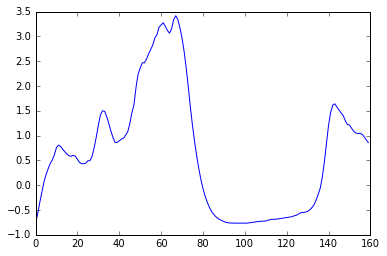

In [3]:
plt.plot(data[-1][0][0])
plt.show()

Here is where we build the reservoir computing model. We first specify the parameters of the network, such as the leak rate, the input weights and strength, and the recurrent reservoir weights. We next set the spectral radius (maximum eigenvalue) parameter for the reservoir weights. In practice, a value less than unity leads to convergent dynamics and a short memory, while a value greater than unity leads to divergent dynamics and a long memory. Values close to unity typically give the best results. Here, we set the value to 1.0.

In [4]:
# generate the ESN reservoir weights
a = 0.12 # leaking rate

# set input weights and scaling parameter
W_in = 0.6 * (np.random.rand(200, 31)-0.5)

# set reservoir weights
W_res = (np.random.rand(200, 200)-0.5)

# set spectral radius parameter
rhoW_res = max(abs(eig(W_res)[0]))
W_res *= 1.0 / rhoW_res

Next, we simulate the reservoir with random data from the dataset. We initialize arrays for the reservoir states, which we will use to collect the trajectories of the reservoir as we show it the input. We will average over this trajectory to get a single averaged reservoir state, which is what we will use as input to the final linear classifier.

In [5]:
#Simulate the reservoir

#C are integrated reservoir states, T are targets
C = []
T = []

#randomly pick category and data point
for itr in xrange(10000):
    R = []
    r = np.zeros(200)
    ctg = np.random.randint(1, 30)
    rnd = np.random.randint(0,150)
    
    #run the reservoir with the current data point
    for t in xrange(np.shape(data[ctg][rnd])[1]):
        x = data[ctg][rnd][:,t]
        r = (1-a)*r + a*np.tanh(np.dot(W_in, x) + np.dot(W_res, r))
        R.append(r)
        
    #integrate the reservoir state over time
    R_int = np.sum(R, axis=0)
    
    #add reservoir state and target to C
    C.append(R_int)
    T.append(ctg)
    
    if itr%1000 == 0:
        print 'iteration number: ' + str(itr)

iteration number: 0
iteration number: 1000
iteration number: 2000
iteration number: 3000
iteration number: 4000
iteration number: 5000
iteration number: 6000
iteration number: 7000
iteration number: 8000
iteration number: 9000


Now that we've collected and averaged over our reservoir states, we can train the output weights on the actual labels that resulted in the associated reservoir states. First, we encode our labels in one-hot format. Then we use scikit-learn's ridge regression to train a linear classifier between the reservoir states C and our targets.

In [6]:
Targets = np.zeros((len(T), 31))

for i, vec in enumerate(Targets):
    Targets[i][T[i]] = 1
    
clf = Ridge(alpha = 0.5)
clf.fit(C, Targets)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Finally, we can run new data through the reservoir and do classification. We print our overall accuracy at the end.

In [7]:
#run reservoir on validation data

C_test = []
T_test = []
r = np.zeros(200)

for itr in xrange(100):
    R_test = []
    ctg = np.random.randint(1, 30)
    rnd = np.random.randint(150,200)
    
    for t in xrange(np.shape(data[ctg][rnd])[1]):
        x = data[ctg][rnd][:,t]
        r = (1-a)*r + a*np.tanh(np.dot(W_in, x) + np.dot(W_res, r))
        R_test.append(r)
        
    R_test = np.array(R_test)        
    R_int_test = np.sum(R_test, axis=0)
    C_test.append(R_int_test)
    T_test.append(ctg)
    
Targets_test = np.zeros((len(T_test), 31))

for i, vec in enumerate(Targets_test):
    Targets_test[i][T_test[i]] = 1
    
#determine accuracy
score = 0
for i,n in enumerate(C_test):
    y_pred = clf.predict(C_test[i].reshape(1,-1))
    y = np.argmax(y_pred)
    if y == np.argmax(Targets_test[i]):
        score += 1

print score/len(C_test)

0.56


Ok, so that was a pretty small reservoir trained on a small subset of the actual dataset. So what does it look like when we train a seriously powerful reservoir with the full dataset? We end up getting some impressive results:

In [10]:
neurons = 5000
input_scaling = 0.46
W_in = np.loadtxt('W_in.txt')
a = 0.12
W = np.loadtxt('W.txt')
W_out = np.loadtxt('W_out.txt')

In [13]:
#run reservoir on validation data

C_test = []
T_test = []
r = np.zeros(5000)

for itr in xrange(100):
    R_test = []
    ctg = np.random.randint(1, 30)
    rnd = np.random.randint(150,200)
    
    for t in xrange(np.shape(data[ctg][rnd])[1]):
        x = data[ctg][rnd][:,t]
        r = (1-a)*r + a*np.tanh(np.dot(W_in, x) + np.dot(W, r))
        R_test.append(r)
        
    R_test = np.array(R_test)        
    R_int_test = np.sum(R_test, axis=0)
    C_test.append(R_int_test)
    T_test.append(ctg)
    
Targets_test = np.zeros((len(T_test), 31))

for i, vec in enumerate(Targets_test):
    Targets_test[i][T_test[i]] = 1
    
#determine accuracy
score = 0
for i,n in enumerate(C_test):
    y_pred = np.dot(C[i].reshape(1,-1), W_out)
    y = np.argmax(y_pred)
    if y == np.argmax(Targets_test[i]):
        score += 1

print score/len(C_test)

ValueError: shapes (1,200) and (5000,31) not aligned: 200 (dim 1) != 5000 (dim 0)

## Conclusion

So, what are the takeaways here? Well, if you noticed, actually simulating the reservoir takes far longer than training the output weights. This is because of the huge matrix multiplication that we do for each timestep when simulating the reservoir. Neuromorphic architectures have the ability to fully parallelize this step, resulting in much faster execution than a CPU or GPU.

Since there is no backpropagation involved, and the matrix is randomly initialized, the reservoir computing technique is extremely well-suited for implementation in simple analog or memristive neuromorphic architectures. All you need to do is project your input into a randomly connected neuromorphic network and read out the resulting states of the network. Then, just do ridge regression (very efficient), and you have a robust predictor or classifier!